<a href="https://colab.research.google.com/github/federicOO1/LAB-IA/blob/main/test_progetto_LAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import librerie


In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms, utils
import torch.nn as nn
import os
import albumentations as A
import numpy as np
import PIL
import warnings
from tqdm.auto import tqdm
import torch.utils.checkpoint as checkpoint
from albumentations.pytorch import ToTensorV2
import torch.optim as optim
import shutil
import random
import albumentations
!pip install rasterio
import rasterio
from rasterio.plot import reshape_as_image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 59.6 MB/s eta 0:00:00


In [16]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/MyDrive/task1/Potsdam')

Mounted at /content/drive


In [8]:
class PotsdamDataset(Dataset):
    def __init__(self, images_folder, labels_folder, train_val_test, transform=None, mean=None, std=None, size=None):
        self.images_folder = images_folder
        self.labels_folder = labels_folder
        self.train_val_test = train_val_test
        self.image_paths = []
        self.world_file_paths = []
        self.mask_paths = []
        self.transform = transform
        self.mean = mean
        self.std = std
        self.size = size
        self.normalize = transforms.Normalize(mean=mean, std=std)


        img_folder = os.path.join(self.images_folder, train_val_test)
        lbl_folder = os.path.join(self.labels_folder, train_val_test)

        for file_name in os.listdir(img_folder):
          if file_name.endswith('.tif'):
              image_path = os.path.join(img_folder, file_name)
              self.image_paths.append(image_path)
              world_file_path = os.path.join(img_folder, file_name.replace('.tif', '.tfw'))
              if os.path.exists(world_file_path):
                            self.world_file_paths.append(world_file_path)

        for label_name in os.listdir(lbl_folder):
                    mask_path = os.path.join(lbl_folder, label_name)
                    if os.path.exists(mask_path):
                      self.mask_paths.append(mask_path)

        self.image_paths.sort()
        self.world_file_paths.sort()
        self.mask_paths.sort()

    def __len__(self):
        return len(self.image_paths)

    def get_image_paths(self, indices):
        return [self.image_paths[idx] for idx in indices]

    def get_mask_paths(self, indices):
        return [self.mask_paths[idx] for idx in indices]

    def load_world_file(self, world_file_path):
          lines = open(world_file_path).readlines()
          try:
              parameters = [float(line.strip()) for line in lines if line.strip()]
              if len(parameters) == 6:
                  return parameters
              else:
                  raise ValueError("Il file .tfw non contiene 6 parametri.")
          except Exception as e:
              print(f"Errore durante la lettura dei parametri di georeferenziazione: {str(e)}")
              return None

    def RGB_to_class(self, rgb_label):
        # Mappa colori con classe
        colors_to_labels = {
            (255, 255, 255): 0,
            (0, 0, 255): 1,
            (0, 255, 255): 2,
            (0, 255, 0): 3,
            (255, 255, 0): 4,
            (255, 0, 0): 5
        }

        # Trasponi l'array per avere le dimensioni (6000, 6000, 3)
        transposed_label = np.transpose(rgb_label, (1, 2, 0))

        class_label = np.zeros((6000, 6000), dtype=np.int64)

        for color, label in colors_to_labels.items():
            #print("np.array(color).reshape(1, 1, 3)",np.array(color).reshape(1, 1, 3))
            #print("\n\n\n trasp_label:",transposed_label)
            mask = np.all(transposed_label == np.array(color).reshape(1, 1, 3), axis=-1)
            #print("mask:",mask)
            class_label[mask] = label
            #print("\n\n\n class_label:",class_label)

        #class_label_tensor = torch.tensor(class_label, dtype=torch.long)

        return class_label

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        world_file_path = self.world_file_paths[idx]
        mask_path = self.mask_paths[idx]

        image = rasterio.open(image_path).read()

        world_params = self.load_world_file(world_file_path)

        mask = rasterio.open(mask_path).read()

        label = self.RGB_to_class(mask)

        if self.transform is not None:
            # Transponi l'immagine per avere le dimensioni (C, H, W)
            #print("1",image.shape)
            image = image.transpose(1, 2, 0)
            #print("image:",image.shape,"label:",label.shape)
            augmented = self.transform(image=image,mask=label)
            image = augmented['image'].numpy()
            label = augmented['mask'].numpy()
            #print("image:",image.shape,"label:",label.shape)

        return image, label

    def normalize(self, image, mean=None, std=None):
        if mean is not None and std is not None:
            # Converte l'immagine in float
            image = torch.tensor(image)
            image = image.float()

            # Normalizza per canale
            for c in range(image.size(0)):
                image[c] = (image[c] - mean[c]) / std[c]

        return image.numpy()

Codice per verificare la correttezza della data augmentation

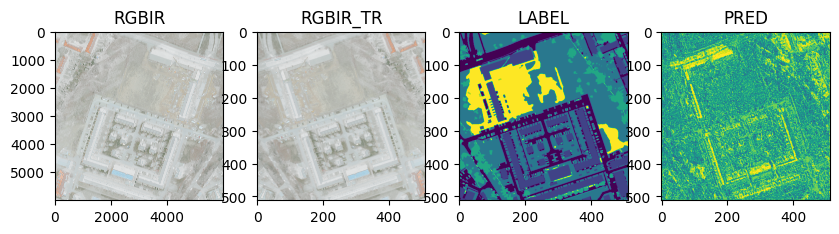

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RGBIR_folder = '/content/drive/MyDrive/task1/Potsdam/4_Ortho_RGBIR'
LABELS_folder = '/content/drive/MyDrive/task1/Potsdam/5_Labels_all'
total_mean = torch.tensor([86.7113, 92.8464, 86.2080, 98.1235]) # per non far girare ogni volta il loop per il calcolo della media e della std
total_std = torch.tensor([35.2340, 35.0720, 36.5135, 35.6512])
IMAGE_HEIGHT = 512
IMAGE_WIDTH = 512

transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.RandomRotate90(),
    A.VerticalFlip(),
    A.HorizontalFlip(),
    A.Normalize(
              mean=(0, 0, 0, 0),
              std=(1, 1, 1, 1),
              max_pixel_value=255.0,
            ),
    ToTensorV2()
])


dataset_train = PotsdamDataset(RGBIR_folder, LABELS_folder, 'train')
transformed_dataset_train = PotsdamDataset(RGBIR_folder, LABELS_folder, 'train', transform=transform, size=IMAGE_HEIGHT)

#print("image shape: ", dataset_train[0][0].shape, "\nlabel shape:",dataset_train[0][1].shape,"\n\n\n",dataset_train[0],"\n\n\n")
#print("image shape: ", transformed_dataset_train[0][0].shape, "\nlabel shape:",transformed_dataset_train[0][1].shape,"\n\n\n",transformed_dataset_train[0],"\n\n\n")
rgbir = dataset_train[0][0]
transformed_list = transformed_dataset_train[0]
rgbir_tr = transformed_list[0]
label = transformed_list[1]

model = UNet(in_channels=4, out_channels=6)  # Input con 4 canali e output con 6 classi
input_data = torch.from_numpy(rgbir_tr).unsqueeze(0)  # Esempio di input con dimensioni 256x256
output = model(input_data)
output = output.squeeze(0)  # Rimuovi la dimensione del batch se presente
output_probabilities = F.softmax(output, dim=0)  # Applica la softmax per ottenere le probabilità per ogni classe
predicted_labels = torch.argmax(output_probabilities, dim=0)

fig, axs = plt.subplots(1, 4, figsize=(10, 5))

# Plotta le immagini sui rispettivi assi
axs[0].imshow(rgbir.transpose(1, 2, 0))
axs[0].set_title('RGBIR')

axs[1].imshow(rgbir_tr.transpose(1, 2, 0))
axs[1].set_title('RGBIR_TR')

axs[2].imshow(label)
axs[2].set_title('LABEL')

axs[3].imshow(predicted_labels)
axs[3].set_title('PRED')
plt.show()

# Model


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConvolution(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConvolution, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, features=[64,128,256,512]):
        super(UNet, self).__init__()

        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        for feature in features:
          self.downs.append(DoubleConvolution(in_channels, feature))
          in_channels = feature

        for feature in reversed(features):
          self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
          self.ups.append(DoubleConvolution(feature*2, feature))

        self.bottleneck = DoubleConvolution(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)  # Modifica il numero di canali di output

    def forward(self, x):

        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for i in range(0,len(self.ups),2):
            x = self.ups[i](x)
            skip_connection = skip_connections[i//2]

            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:], mode='bilinear', align_corners=True)

            concat_skip = torch.cat((skip_connection,x), dim=1)
            x = self.ups[i+1](concat_skip)

        x = self.final_conv(x)

        return x



# Training e validazione


In [14]:
LEARNING_RATE = 0.01
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 4
LOAD_MODEL = False
NUM_EPOCHS = 2
NUM_WORKERS = 1
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
best_mIoU = 0.0
train_losses_global = []
val_losses_global = []
val_iou_global = []

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import cv2

def train(model, loader, criterion, optimizer, device, scaler):
    model.train()
    running_loss = 0.0
    for inputs, targets in tqdm(loader):
        inputs, targets = inputs.to(device), targets.to(device, dtype=torch.long)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item() * inputs.size(0)
        print(loss.item(), inputs.size(0), running_loss)
    return running_loss / len(loader.dataset)

def evaluate(model, loader, device, num_classes):
    model.eval()
    total_iou = 0.0
    total_miou = 0.0
    total_accuracy = 0.0
    total_loss = 0.0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for inputs, targets in tqdm(loader):
            inputs, targets = inputs.to(device), targets.to(device, dtype=torch.long)
            outputs = model(inputs)
            predictions = outputs.argmax(dim=1)
            ious_per_batch = calculate_iou(predictions, targets, num_classes)
            miou = calculate_miou(predictions, targets, num_classes)
            accuracy = calculate_overall_accuracy(predictions, targets)
            loss = criterion(outputs, targets)
            total_iou += sum(ious_per_batch) / num_classes * inputs.size(0)
            total_miou += miou * inputs.size(0)
            total_accuracy += accuracy * inputs.size(0)
            total_loss += loss.item() * inputs.size(0)
    dataset_size = len(loader.dataset)
    return total_loss / dataset_size, total_iou / dataset_size, total_miou / dataset_size, total_accuracy / dataset_size



def calculate_iou(prediction, target, num_classes):
    iou_per_class = []
    for cls in range(num_classes):
        intersection = torch.logical_and(prediction == cls, target == cls).sum().item()
        union = torch.logical_or(prediction == cls, target == cls).sum().item()
        iou = intersection / union if union > 0 else 0
        iou_per_class.append(iou)
    return iou_per_class

def calculate_miou(predictions, targets, num_classes): #average miou
    miou_per_batch = []
    for prediction, target in zip(predictions, targets):
        iou_per_class = calculate_iou(prediction, target, num_classes)
        miou = sum(iou_per_class) / num_classes
        miou_per_batch.append(miou)
        return sum(miou_per_batch) / len(miou_per_batch)

def plot_metrics(train_losses, val_losses, val_iou, val_miou, val_accuracy):
    global NUM_EPOCHS
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Train and Validation Losses')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(val_iou, label='Validation IoU', color='green')
    plt.plot(val_miou, label='Validation mIoU', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()
    plt.title('Validation IoU and mIoU')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 6))
    epochs = range(NUM_EPOCHS)
    plt.bar(epochs, val_accuracy, color='purple', alpha=0.7)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Overall Accuracy per Epoch')
    plt.grid(axis='y')
    for i, acc in enumerate(val_accuracy):
        plt.text(i + 1, acc + 0.01, f'{acc:.4f}', ha='center', va='bottom')
    plt.show()

def calculate_overall_accuracy(predictions, targets):
    correct_pixels = (predictions == targets).sum().item()
    total_pixels = predictions.numel()
    return correct_pixels / total_pixels

'''# Definisci la funzione per calcolare l'IoU
def calculate_iou(predictions, targets):
    intersection = torch.logical_and(predictions, targets).sum().float()
    union = torch.logical_or(predictions, targets).sum().float()
    iou = (intersection + 1e-6) / (union + 1e-6)  # Aggiungi epsilon per evitare divisione per zero
    return iou.item()'''


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.RandomRotate90(),
    A.VerticalFlip(),
    A.HorizontalFlip(),
    A.Normalize(
              mean=(0, 0, 0, 0),
              std=(1, 1, 1, 1),
              max_pixel_value=255.0,
            ),
   ToTensorV2(always_apply=True),
        ]
    )
val_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=(0, 0, 0, 0),
                std=(1, 1, 1, 1),
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ]
)

model = UNet(in_channels=4, out_channels=6).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()

transformed_dataset_train = PotsdamDataset(RGBIR_folder, LABELS_folder, 'train', transform=train_transform, size=IMAGE_HEIGHT)
transformed_dataset_val = PotsdamDataset(RGBIR_folder, LABELS_folder, 'val', transform=val_transform, size=IMAGE_HEIGHT)

train_loader = DataLoader(transformed_dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(transformed_dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

train_losses = []
val_losses = []
val_iou = []
val_miou = []

# Addestramento del modello

for epoch in range(NUM_EPOCHS):
    train_loss = train(model, train_loader, criterion, optimizer, device, scaler)
    train_losses.append(train_loss)

    val_loss, val_iou_value, val_miou_value, val_accuracy = evaluate(model, val_loader, device, 6)
    val_losses.append(val_loss)
    val_iou.append(val_iou_value)
    val_miou.append(val_miou_value)

    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation IoU: {val_iou_value:.4f}, Validation mIoU: {val_miou_value:.4f}, Validation Accuracy: {val_accuracy:.4f}')

plot_metrics(train_losses, val_losses, val_iou, val_miou, val_accuracy)

torch.save(model.state_dict(), 'model.pth')


/usr/local/lib/python3.10/dist-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


1.7404214143753052 4 6.961685657501221


1.5829163789749146 4 13.293351173400879


1.4799400568008423 4 19.213111400604248


1.4140113592147827 4 24.86915683746338


1.2790969610214233 4 29.985544681549072
1.3097065687179565 4 35.2243709564209
1.269152283668518 2 37.762675523757935


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Epoch [1/2], Train Loss: 1.4524, Validation Loss: 159237.5417, Validation IoU: 0.0384, Validation mIoU: 0.0483, Validation Accuracy: 0.2304


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


RuntimeError: DataLoader worker (pid 48796) is killed by signal: Killed. 